<a href="https://colab.research.google.com/github/10-Academy-Batch-4-Week-4/Swahili-Speech-To-Text/blob/main/SpeechRecognitionPreProcess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#load packages
import json
import os
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
%matplotlib inline
import librosa
import librosa.display
import IPython.display as  ipd
import torch
import torchaudio
from torchaudio import transforms

In [3]:
os.chdir("drive/My Drive/train")
os.listdir()

['spk2utt', 'utt2spk', 'wav.scp', 'wav', 'text.txt']

# Load audio file

In [4]:
DATASET_PATH = "wav"
SAMPLE_RATE = 22050
labels=[]
def preprocess(dataset_path):
    # dictionary to store files
    
    # loop through all sub-folders
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):

        # ensure we're processing at sub-folder level
        if dirpath is not dataset_path:

            # save label (i.e., sub-folder name) in the mapping eg SWH-05-20101106
            label = dirpath.split("/")[-1]
           
            print("\nProcessing: {}".format(label))

            # process all audio files in genre sub-dir
            for f in filenames:

		        # load audio file
                filename="wav/"+label+"/"+f
                labels.append(filename)
                 
if __name__ == "__main__":
    preprocess(DATASET_PATH)


Processing: SWH-05-20101106

Processing: SWH-05-20101107

Processing: SWH-05-20101109

Processing: SWH-05-20101110

Processing: SWH-05-20101111

Processing: SWH-05-20101112

Processing: SWH-05-20101113

Processing: SWH-05-20101121

Processing: SWH-05-20101123

Processing: SWH-05-20110114

Processing: SWH-05-20110123

Processing: SWH-05-20110125

Processing: SWH-05-20110215

Processing: SWH-05-20110317

Processing: SWH-05-20110321

Processing: SWH-05-20110327

Processing: SWH-15-20101103

Processing: SWH-15-20101104

Processing: SWH-15-20101109

Processing: SWH-15-20101113

Processing: SWH-15-20101115

Processing: SWH-15-20101117

Processing: SWH-15-20101130

Processing: SWH-15-20101227

Processing: SWH-15-20110124

Processing: SWH-15-20110126

Processing: SWH-15-20110207

Processing: SWH-15-20110224

Processing: SWH-15-20110303

Processing: SWH-15-20110310


In [5]:
len(labels)

10180

# Load transcriptions

In [6]:
df=pd.read_csv("text.txt",sep="\t",header=None)
df = df.drop([0],axis=1)
df.columns=['text']
df.head()

,text
0,rais wa tanzania jakaya mrisho kikwete
1,yanayo andaliwa nami pendo pondo idhaa ya kisw...
2,inayokutangazia moja kwa moja kutoka jijini da...
3,juma hili bara la afrika limeshuhudia raia wa ...
4,wakipiga kura ya maoni ilikufanya mabadiliko ya


In [7]:
df.shape[0]

10180

In [8]:
df['audio']=labels
df.head()

,text,audio
0,rais wa tanzania jakaya mrisho kikwete,wav/SWH-05-20101106/SWH-05-20101106_16k-emissi...
1,yanayo andaliwa nami pendo pondo idhaa ya kisw...,wav/SWH-05-20101106/SWH-05-20101106_16k-emissi...
2,inayokutangazia moja kwa moja kutoka jijini da...,wav/SWH-05-20101106/SWH-05-20101106_16k-emissi...
3,juma hili bara la afrika limeshuhudia raia wa ...,wav/SWH-05-20101106/SWH-05-20101106_16k-emissi...
4,wakipiga kura ya maoni ilikufanya mabadiliko ya,wav/SWH-05-20101106/SWH-05-20101106_16k-emissi...


In [9]:
def clean_column(data:pd.DataFrame,col:str):
  words_list=[' UNK ', ' music ', ' laughter ']
  data = data[~data[col].isin(words_list)]
  for row in data[col]:
    for punctuation in string.punctuation:
        row = row.replace(punctuation," ")
    return row
  return data

In [10]:
clean_column(df,'text')

'rais wa tanzania jakaya mrisho kikwete'

# EDA

In [11]:
def audio_test(data:pd.DataFrame,col:str,row:int):
  file=data[col].loc[row]
  plt.figure(figsize=(12,6))
  signal,sample_rate=librosa.load(file)
  librosa.display.waveplot(signal,sr=sample_rate)
  plt.xlabel('Time')
  plt.ylabel('Amplitude')
  plt.show()
  return ipd.Audio(file)

def plot_eda(data:pd.DataFrame,col:str,row:int):
  file=data[col].loc[row]
  signal,sample_rate=librosa.load(file)

  #fft inputs
  fft = np.fft.fft(signal)
  magnitude=np.abs(abs(fft))
  frequency = np.linspace(0,sample_rate,len(magnitude))
  left_magnitude=magnitude[:int(len(magnitude)/2)]
  left_frequency=frequency[:int(len(frequency)/2)]

  #spectrogram inputs
  n_fft = 2048 #amount of samples
  hop_length= 512 #how much we're sliding towards the right

  plt.figure(figsize=(12,8))

  plt.subplot(2,2,1)
  plt.plot(frequency,magnitude)
  plt.xlabel('frequency')
  plt.ylabel('magnitude')
  plt.title('FFT plot of frequency against magnitude')

  plt.subplot(2,2,2)
  plt.plot(left_frequency,left_magnitude)
  plt.xlabel('frequency')
  plt.ylabel('magnitude')
  plt.title('FFT plot of frequency against magnitude')

  plt.subplot(2,2,3)
  stft=librosa.core.stft(signal, n_fft=n_fft, hop_length=hop_length)
  spectrogram = np.abs(stft)
  log_spectrogram=librosa.amplitude_to_db(spectrogram)
  librosa.display.specshow(log_spectrogram,sr=sample_rate,hop_length=hop_length)
  plt.xlabel("Time")
  plt.ylabel("Frequency")
  plt.title('Spectrogram plot of frequency against time')
  plt.colorbar()

  plt.subplot(2,2,4)
  MFCCs=librosa.feature.mfcc(signal,n_fft=n_fft,hop_length=hop_length,n_mfcc=13)
  librosa.display.specshow(MFCCs,sr=sample_rate,hop_length=hop_length)
  plt.xlabel("Time")
  plt.ylabel("MFCC")
  plt.title('MFCC plot of frequency against time')
  plt.colorbar()

  plt.show()

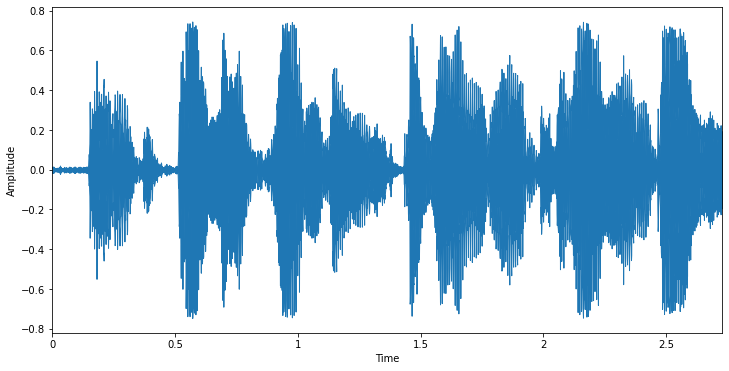

In [12]:
audio_test(df,'audio',9908)

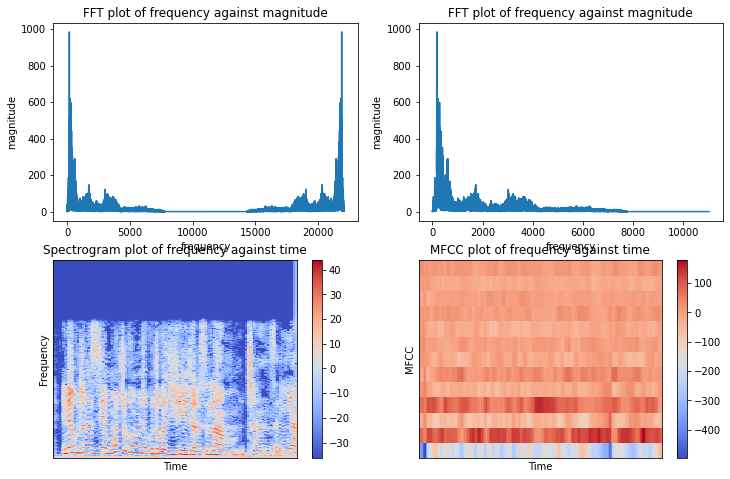

In [13]:
plot_eda(df,'audio',2)

**Most energy is concentrated in the lower frequencies**

# Convert into channels

* Some of the sound files are mono (ie. 1 audio channel) while most of them are stereo (ie. 2 audio channels). 
* Since the Neural network model expects all items to have the same dimensions, we will convert the mono files to stereo, by duplicating the first channel to the second



Check whether sound files are mono or stereo

In [14]:
chan=[]
for i in df['audio']:
  sig, sr = torchaudio.load(i)
  sig_shape=sig.shape[0]
  chan.append(sig_shape)

In [15]:
#getting unique values from list
set_channel=set(chan)
print('Unique sound signals',set_channel)

Unique sound signals {1}


Audio files are all mono